In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorkrowch as tk

In [2]:
torch.set_num_threads(1)
cwd = os.getcwd()
cwd = os.path.join(cwd, '..', '..')

## AKLT

In [4]:
n_features_list = [100, 200, 500]
samples_size = 100
sketch_size_list = [2, 4, 6, 8, 10, 12, 14]

results_dir = os.path.join(cwd, 'results', '4_interpretability', 'aklt')

fidelities_aklt = {}
order_aklt = {}
times_aklt = {}

for n_features in n_features_list:
    for sketch_size in sketch_size_list:
        aux_dir = f'rss_{n_features}_{samples_size}_{sketch_size}'
        files = os.listdir(os.path.join(results_dir, aux_dir))
        
        aux_fidelities = torch.Tensor([float(f.split('_')[3]) for f in files])
        aux_order = torch.Tensor([float(f.split('_')[5][:-3]) for f in files])
        aux_times = torch.Tensor([float(f.split('_')[0]) for f in files])
        
        # Remove outliers
        aux_fidelities, ids = aux_fidelities.sort()
        aux_times = aux_times[ids]
        
        q = torch.Tensor([0.25, 0.75])
        quantiles = aux_fidelities.quantile(q=q)
        iqr = quantiles[1] - quantiles[0]
        cond = (aux_fidelities >= (quantiles[0] - 1.5 * iqr)) * (aux_fidelities <= (quantiles[1] + 1.5 * iqr))
        
        aux_fidelities = aux_fidelities[cond]
        aux_order = aux_order[cond]
        aux_times = aux_times[cond]
        
        if n_features not in fidelities_aklt:
            fidelities_aklt[n_features] = [(aux_fidelities.mean(), aux_fidelities.std())]
            order_aklt[n_features] = [(aux_order.mean(), aux_order.std())]
            times_aklt[n_features] = [(aux_times.mean(), aux_times.std())]
        else:
            fidelities_aklt[n_features].append((aux_fidelities.mean(), aux_fidelities.std()))
            order_aklt[n_features].append((aux_order.mean(), aux_order.std()))
            times_aklt[n_features].append((aux_times.mean(), aux_times.std()))

fidelities_aklt

{100: [(tensor(3.0594e-08), tensor(4.7548e-08)),
  (tensor(0.0071), tensor(0.0077)),
  (tensor(0.4994), tensor(0.2450)),
  (tensor(0.6464), tensor(0.0934)),
  (tensor(1.), tensor(0.)),
  (tensor(1.), tensor(0.)),
  (tensor(1.), tensor(0.))],
 200: [(tensor(2.7146e-16), tensor(3.7456e-16)),
  (tensor(0.0001), tensor(0.0002)),
  (tensor(0.0896), tensor(0.0495)),
  (tensor(0.5232), tensor(0.2962)),
  (tensor(0.8914), tensor(0.1837)),
  (tensor(1.), tensor(0.)),
  (tensor(1.), tensor(0.))],
 500: [(tensor(1.1256e-39), tensor(1.5738e-39)),
  (tensor(6.1209e-10), tensor(9.6719e-10)),
  (tensor(0.0016), tensor(0.0011)),
  (tensor(0.1281), tensor(0.0818)),
  (tensor(0.6682), tensor(0.2134)),
  (tensor(0.8415), tensor(0.2159)),
  (tensor(1.), tensor(0.))]}

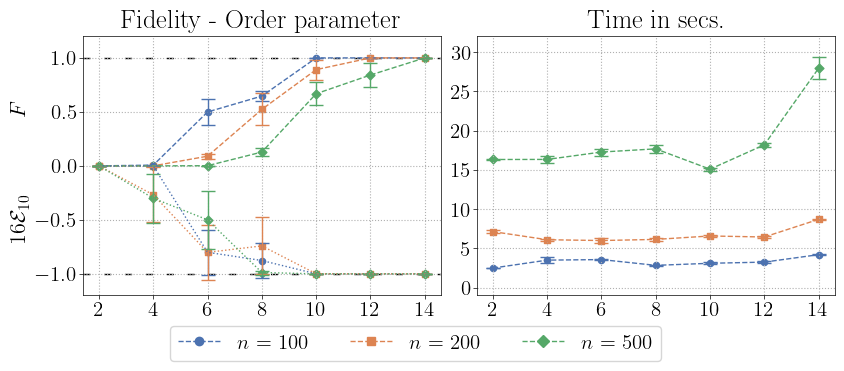

In [9]:
palette = sns.color_palette("deep")
colors = palette[0], palette[1], palette[2]

plt.rc('font', family='serif', serif='Computer Modern', size=16)
plt.rc('text', usetex=True)


# Set global font sizes
plt.rcParams['axes.linewidth'] = 0.5  # Default is usually 1.0
plt.rcParams['axes.titlesize'] = 19  # Title font size
plt.rcParams['axes.labelsize'] = 17  # Axis label font size
plt.rcParams['xtick.labelsize'] = 15  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 15  # Y-axis tick label font size
plt.rcParams['legend.fontsize'] = 15

markers = ['o', 's', 'D']
labels = [r'$n$ = 100', r'$n$ = 200', r'$n$ = 500']

fig, axs = plt.subplots(1, 2, figsize=(8.5, 3.25))


# Slater
# ------
sketch_size_list = [2, 4, 6, 8, 10, 12, 14]

# Errors
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 fidelities_aklt[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                fidelities_aklt[n_features]))).tolist()

    axs[0].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                    linestyle='--', linewidth=1., color=colors[i])
    axs[0].scatter(x=sketch_size_list, y=means, s=20.,
                   color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[0].set_title('Fidelity - Order parameter')

axs[0].set_ylim(-1.2, 1.2)
axs[0].yaxis.grid(linestyle=':')
axs[0].xaxis.grid(linestyle=':')

axs[0].set_xticks(torch.arange(2, 16, 2))
axs[0].set_yticks(torch.arange(-1., 1.2, .5))

axs[0].axhline(y=1., linestyle=(0, (5, 10)), linewidth=1.,
               color='black', zorder=-1)

axs[0].text(0.023, 0.675, r'$F$', transform=fig.transFigure,
            rotation='vertical', verticalalignment='center')

# Order parameters
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 order_aklt[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                order_aklt[n_features]))).tolist()

    axs[0].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                    linestyle=':', linewidth=1., color=colors[i])
    axs[0].scatter(x=sketch_size_list, y=means, s=20.,
                   color=colors[i], marker=markers[i])

# Set axes
axs[0].axhline(y=-1., linestyle=(0, (5, 10)), linewidth=1.,
               color='black', zorder=-1)

axs[0].text(0.023, 0.34, r'$16\mathcal{E}_{10}$', transform=fig.transFigure,
            rotation='vertical', verticalalignment='center')

# Times
for i, n_features in enumerate([100, 200, 500]):
    means = torch.stack(list(map(lambda t: t[0],
                                 times_aklt[n_features]))).tolist()
    stds = torch.stack(list(map(lambda t: t[1] * 0.5,
                                times_aklt[n_features]))).tolist()

    axs[1].errorbar(x=sketch_size_list, y=means, yerr=stds, capsize=5.,
                    linestyle='--', linewidth=1., color=colors[i])
    axs[1].scatter(x=sketch_size_list, y=means, s=20.,
                   color=colors[i], marker=markers[i], label=labels[i])

# Set axes
axs[1].set_title('Time in secs.')

# axs[1].set_ylim(-2, 25)
axs[1].set_ylim(-1, 32)
axs[1].yaxis.grid(linestyle=':')
axs[1].xaxis.grid(linestyle=':')

axs[1].set_xticks(torch.arange(2, 16, 2))
# axs[1].set_yticks(torch.arange(0, 22, 5))
axs[1].set_yticks(torch.arange(0, 32, 5))


# Create custom legend handles
from matplotlib.lines import Line2D

custom_handles = [
    Line2D([0], [0], color=color, linestyle='--', marker=marker, markersize=6, linewidth=1., label=label)
    for color, marker, label in zip(colors, markers, labels)
]

# Add a single legend to the figure
fig.legend(
    handles=custom_handles,
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.13),  # Centered below the plots
    # frameon=False
)


plt.tight_layout(pad=0.25)

for i in range(2):
    axs[i].tick_params(axis='both', which='major', pad=1,
                       direction='out', length=3, width=0.5)  # Default is usually around 6-10
    axs[i].tick_params(axis='both', which='minor', pad=1,
                       direction='out', length=3, width=0.5)
    

results_dir = os.path.join(cwd, 'results', '4_interpretability', 'aklt')
plt.savefig(os.path.join(results_dir, 'performance_aklt.pdf'),
            bbox_inches='tight')

plt.show()